In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('default')

from string import punctuation
from math import trunc

In [2]:
df = pd.read_csv('/kaggle/input/credit-score-classification/train.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [3]:
df.isna().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

##### **HANDLING MISSING VALUES**

In [4]:
# Column -> Name

lookup = (df.dropna(subset=['Name']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Name'])

df['Name'] = df['Customer_ID'].map(lookup).fillna(df['Name'])

In [5]:
# Column -> Monthly_Inhand_Salary

lookup = (df.dropna(subset=['Monthly_Inhand_Salary']).drop_duplicates(subset='Customer_ID').set_index('Customer_ID')['Monthly_Inhand_Salary'])

df['Monthly_Inhand_Salary'] = df['Customer_ID'].map(lookup).fillna(df['Monthly_Inhand_Salary'])

In [6]:
# Column -> Type_of_Loan

# type of loans a customer can acquire
loan_types = list()
def types(x):
  if type(x) == list:
    for i in x:
      i = i.lstrip(' and ')
      if i not in loan_types:
        loan_types.append(i)

df['Type_of_Loan'].str.split(',').apply(lambda x: types(x))
# print(loan_types)

# Checks whether there is a single customer with both missing values and updated values in all their transactions
# There isn't thus if a null values is present it is present for all the customers transactions.
ax = df.loc[(df['Type_of_Loan'].isna())].drop_duplicates(subset='Customer_ID')
bx = df.dropna(subset='Type_of_Loan').drop_duplicates(subset='Customer_ID')
  
values = set(ax['Customer_ID'])
cx = bx['Customer_ID'].isin(values).astype(object) # lookup
# print(cx.any() == True)

# The null values have to filled as not specified and can't be dropped as they are many 10% of the dataset.
df['Type_of_Loan'].fillna(value='Not Specified',inplace=True)

In [7]:
# Num_of_Delayed_Payment

# Convert the values into numerical and remove special characters
def rem_xtr(x):
  if type(x) == list:
    for c in x:
      if c in list(punctuation):
        x.remove(c)
    return int(''.join(str(c) for c in x).strip())

df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.split('').apply(lambda x: rem_xtr(x))

# Use the Median to fill the null values
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna((df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform('median')))

In [8]:
# Num_Credit_Inquiries

# Non-values for each customer are the almost all similar for the different months.
# I'll just use the median to update the null values.

df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].fillna(df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform('median'))

In [9]:
# Credit_History_Age

# The month value increments per month.
MONTHS = {'January': 0, 'February': 1, 'March': 2, 'April': 3, 'May': 4, 'June': 5, 'July': 6, 'August': 7}

# First non-null month for each customer
first_month = (df.dropna(subset='Credit_History_Age').drop_duplicates(subset='Customer_ID')[['Customer_ID', 'Month', 'Credit_History_Age']])

# Null-months for each customer
null_months = (df.loc[df['Credit_History_Age'].isna()][['Customer_ID', 'Month', 'Credit_History_Age']])

# Fill null values
def fill(x):
  nm = null_months['Month'].loc[(null_months['Customer_ID'] == x) & (null_months['Credit_History_Age'].isna())].tolist() # Null month

  fm = first_month.loc[first_month['Customer_ID'] == x]['Month'].tolist().pop() # First month
  cs = first_month.loc[first_month['Customer_ID'] == x]['Credit_History_Age'].tolist().pop()

  (y, m) = cs.strip('Months').split('Years and')
  (y, m) = (int(y), int(m))

  for i in nm:
    if MONTHS.get(i) > MONTHS.get(fm):
      new_m = m + MONTHS.get(i)
      if new_m >= 12:
        new_m = new_m - 12
        y = y + 1

    else:
      new_m = m - (MONTHS.get(i) + MONTHS.get(fm))
      if new_m < 0:
        new_m = 12 + new_m
        y = y - 1
      
    v = str(y)+' Years and '+str(new_m)+' Months'
    null_months.loc[(null_months['Customer_ID'] == x) & (null_months['Month'] == i), 'Credit_History_Age'] = v

# dx = df.copy()
null_months['Customer_ID'].map(lambda x: fill(x))

# update the original dataset
df.update(null_months)

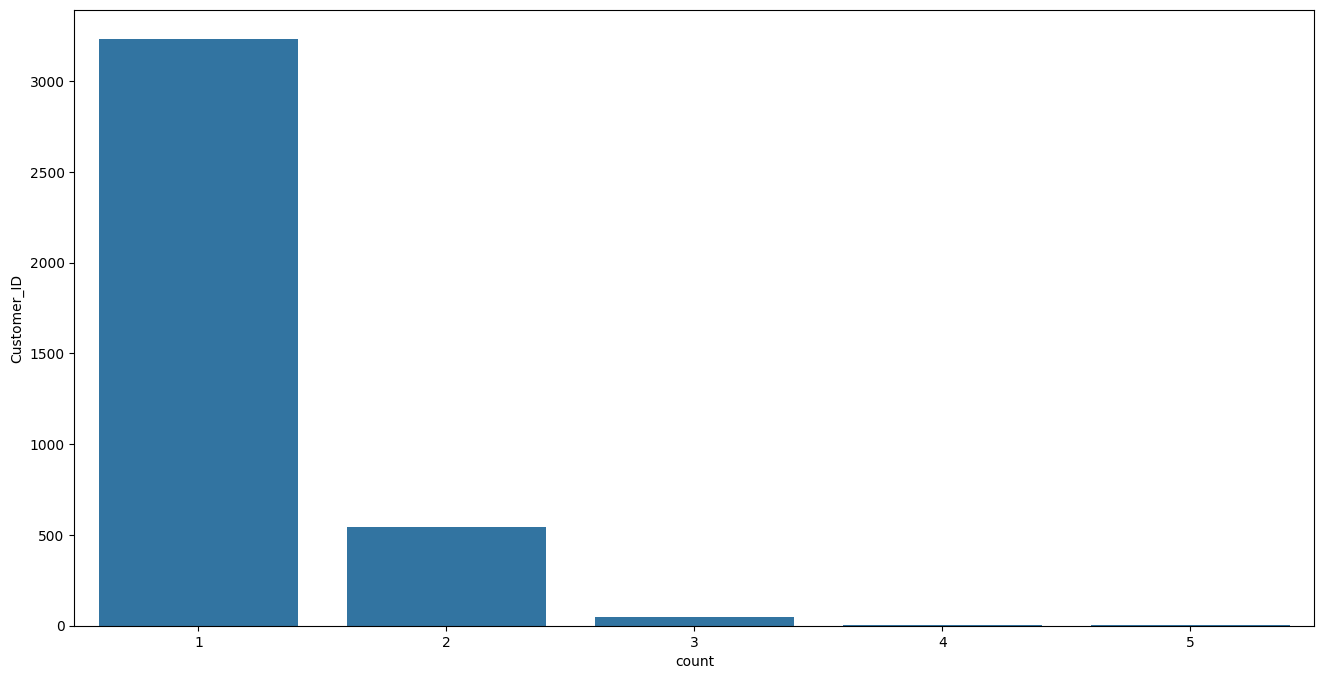

In [10]:
# Amount_invested_monthly

# Depicts the number of null values for each customer.
# As seen most of them have only one missing value in the column.
# Because of this deleting the null values seems won't affect the data also given the null values are only 4% of the dataset.
ex = df.loc[(df['Amount_invested_monthly'].isna())].groupby('Customer_ID', dropna=False)['Name'].value_counts().reset_index().groupby('count').count().reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(data=ex, y='Customer_ID', x='count')
plt.show()

# Removing the null values
df.dropna(subset='Amount_invested_monthly', inplace=True)

In [11]:
# Monthly_Balance

df.dropna(subset='Monthly_Balance', inplace=True)

##### **DATA TRANSFORMATION**

In [12]:
# Age

# Remove special characters and convert into integer
df['Age'] = pd.to_numeric(df['Age'].str.extract(r"(\d+)")[0], errors='coerce')

df.loc[(df['Age'] < 10) | (df['Age'] > 60), 'Age'] = np.nan

df['Age'] = df.groupby('Customer_ID')['Age'].transform(lambda x: x.fillna(trunc(x.median())))

df['Age'] = df['Age'].astype('Int64')

In [13]:
# SSN

# Contains #F%$D@*&8 which we are going to update with the existing values.
df['SSN'] = df['SSN'].replace({'#F%$D@*&8': np.nan})

df['SSN'] = df.groupby('Customer_ID')['SSN'].transform(lambda x: x.fillna(x.mode().values[0]))

In [14]:
# Occupation

# Remove the ___ that is contained in the dataset
df['Occupation'] = df['Occupation'].replace({'_______': np.nan})

df['Occupation'] = df.groupby('Customer_ID')['Occupation'].transform(lambda x: x.fillna(x.mode().values[0]))

In [15]:
# Annual_Income

# Remove the _ contained in the values and convert the values into float
df['Annual_Income'] = df['Annual_Income'].str.strip('_').astype(float)

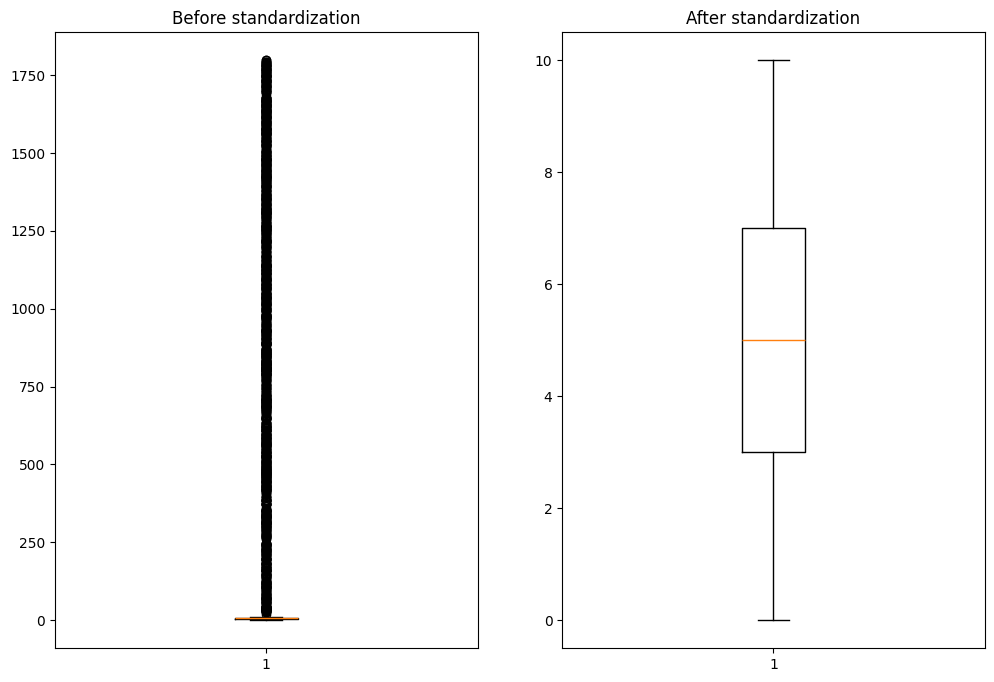

In [16]:
# Num_Bank_Accounts
cf = df.copy()

d1 = cf['Num_Bank_Accounts']
# print(d1.describe())

# Update the offset values with the median of the customers cummulative values
# Contains a lot of outliers
cf.loc[(cf['Num_Bank_Accounts'] < 0) | (cf['Num_Bank_Accounts'] > 10), 'Num_Bank_Accounts'] = np.nan
cf['Num_Bank_Accounts'] = cf.groupby('Customer_ID')['Num_Bank_Accounts'].transform(lambda x: x.fillna(trunc(x.median())))

d2 = cf['Num_Bank_Accounts']
# print(d2.describe())

def plot(d1, d2):
  fig = plt.figure(figsize=(12, 8))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  ax1.boxplot(d1)
  ax1.set_title('Before standardization')

  ax2.boxplot(d2)
  ax2.set_title('After standardization')

  plt.show()

plot(d1, d2)
df.update(cf)

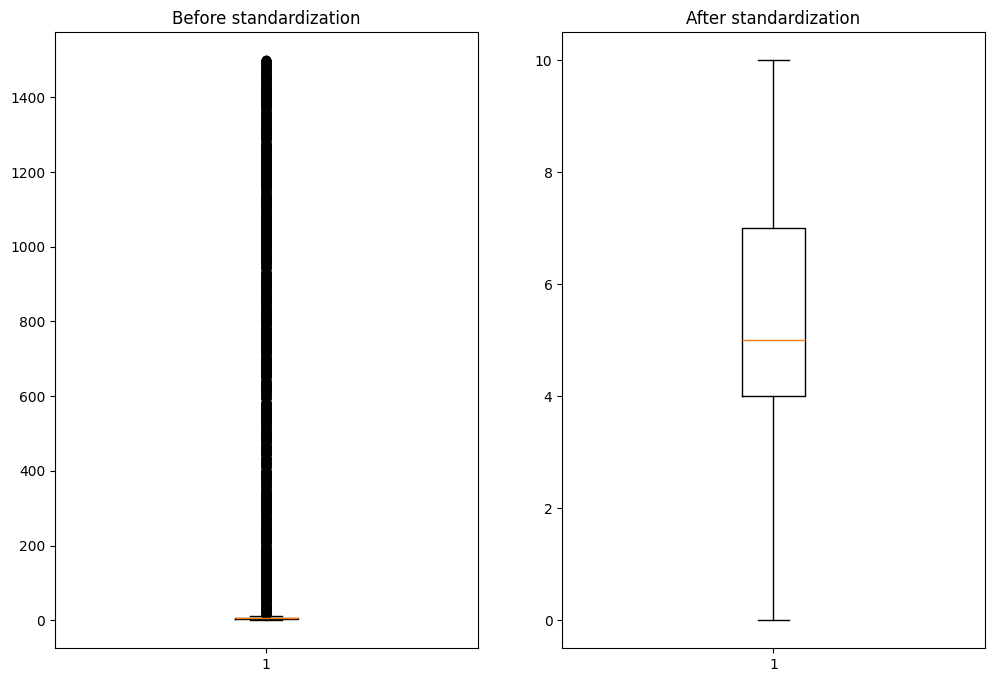

In [17]:
# Num_Credit_Card

# Update the offset values with the median of the customers cummulative values
cf = df.copy()

d1 = cf['Num_Credit_Card']
# print(d1.describe())

cf.loc[(cf['Num_Credit_Card'] < 0) | (cf['Num_Credit_Card'] > 10), 'Num_Credit_Card'] = np.nan
cf['Num_Credit_Card'] = cf.groupby('Customer_ID')['Num_Credit_Card'].transform(lambda x: x.fillna(trunc(x.median())))

d2 = cf['Num_Credit_Card']
# print(d2.describe())

def plot(d1, d2):
  fig = plt.figure(figsize=(12, 8))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  ax1.boxplot(d1)
  ax1.set_title('Before standardization')

  ax2.boxplot(d2)
  ax2.set_title('After standardization')

  plt.show()

plot(d1, d2)
df.update(cf)

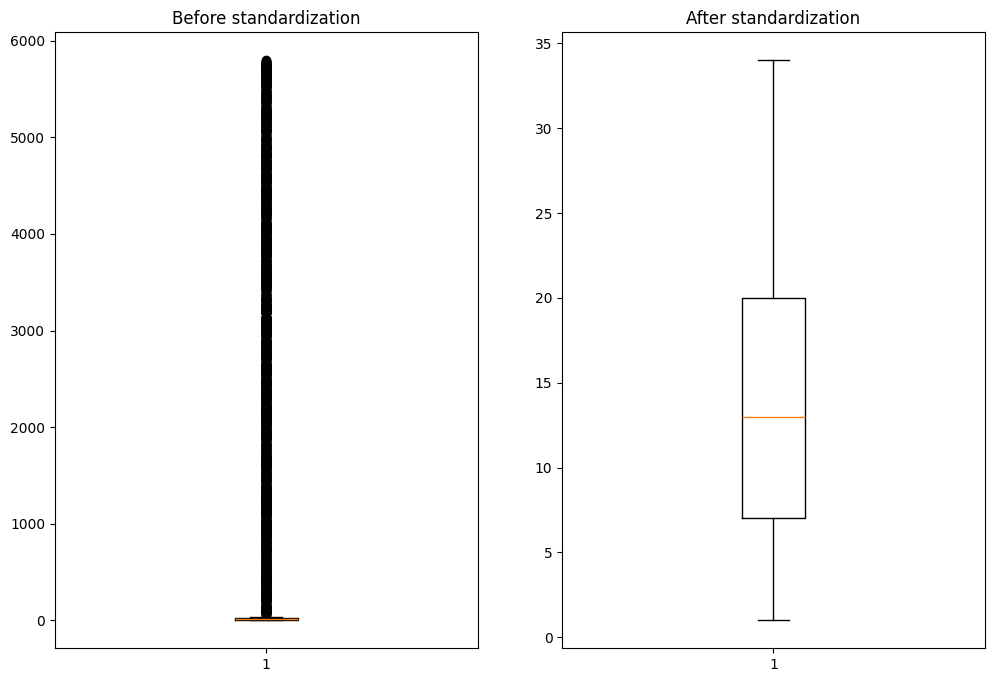

In [18]:
# Interest_Rate

# Update the offset values with the median of the customers cummulative values
cf = df.copy()

d1 = cf['Interest_Rate']
# print(d1.describe())

cf.loc[(cf['Interest_Rate'] > 35), 'Interest_Rate'] = np.nan
cf['Interest_Rate'] = cf.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: x.fillna(trunc(x.mean())))

d2 = cf['Interest_Rate']
# print(d2.describe())

def plot(d1, d2):
  fig = plt.figure(figsize=(12, 8))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  ax1.boxplot(d1)
  ax1.set_title('Before standardization')

  ax2.boxplot(d2)
  ax2.set_title('After standardization')

  plt.show()

plot(d1, d2)
df.update(cf)

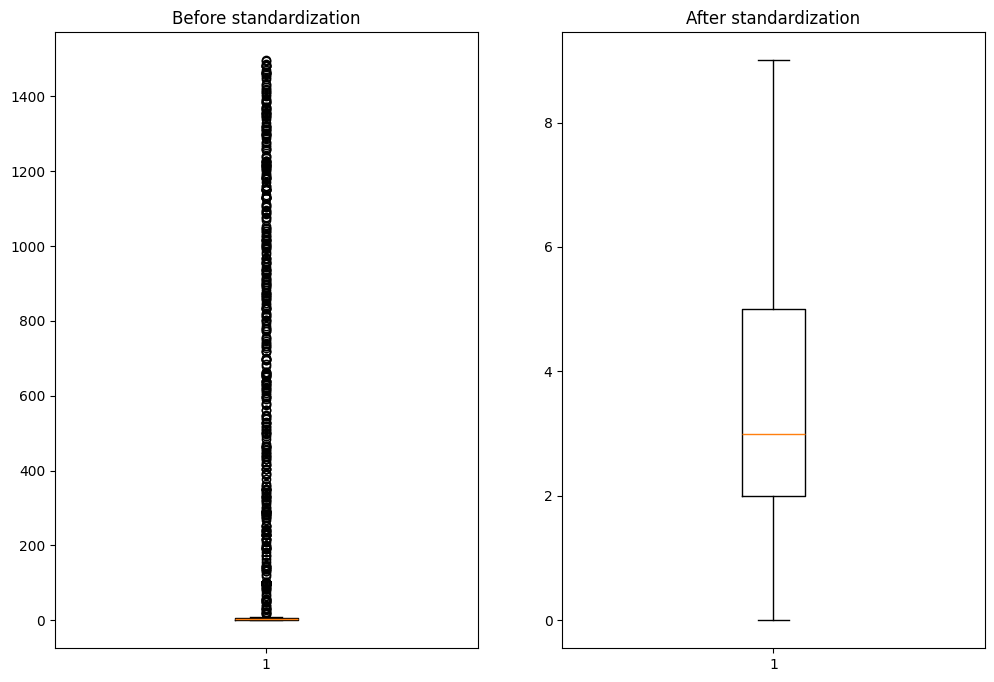

In [19]:
# Num_of_Loan

# Remove special characters and convert into integer
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'].str.extract(r'(\d+)')[0], errors='coerce')

# Update the offset values with the median of the customers cummulative values
px = df.copy()

d1 = px['Num_of_Loan']
# print(d1.describe())

px.loc[(px['Num_of_Loan'] > 10), 'Num_of_Loan'] = np.nan
px['Num_of_Loan'] = px.groupby('Customer_ID')['Num_of_Loan'].transform(lambda x: x.fillna(trunc(x.mean())))

d2 = px['Num_of_Loan']
# print(d2.describe())

def plot(d1, d2):
  fig = plt.figure(figsize=(12, 8))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  ax1.boxplot(d1)
  ax1.set_title('Before standardization')

  ax2.boxplot(d2)
  ax2.set_title('After standardization')

  plt.show()

plot(d1, d2)
df.update(px)

In [20]:
# Outstanding_Debt

df['Outstanding_Debt'] = df['Outstanding_Debt'].str.strip('_').astype(float)

In [21]:
# Changed_Credit_Limit

# Update the offset values with the median of the customers cummulative values
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].replace({'_': np.nan})
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].astype(float)

df['Changed_Credit_Limit'] = df.groupby('Customer_ID')['Changed_Credit_Limit'].transform(lambda x: x.fillna(x.mean()))

In [22]:
# Credit_Mix

# Replace '_' with the mode value for each customer
df['Credit_Mix'] = df['Credit_Mix'].replace({'_': np.nan})
df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].transform(lambda x: x.fillna(x.mode().values[0]))

In [23]:
# Amount_invested_monthly

# Update the offset values with the median of the customers cummulative values
df.loc[(df['Amount_invested_monthly'] == '__10000__') | (df['Amount_invested_monthly'] == '0.0'), 'Amount_invested_monthly'] = np.nan
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].astype(float)


df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda x: x.fillna(x.mean()))

In [24]:
# Payment_Behaviour

# Replace '!@9#%8' with the mode value for each customer
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace({'!@9#%8': np.nan})
df['Payment_Behaviour'] = df.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x: x.fillna(x.mode().values[0]))

In [25]:
# Payment_of_Min_Amount

# Replace NM with the most occuring value for a customer
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace({'NM': np.nan})
df['Payment_of_Min_Amount'] = df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(lambda x: x.fillna(x.mode().values[0]))

In [26]:
# Num_of_Delayed_Payment

# Update the offset values with the median of the customers cummulative values
px = df.copy()

d1 = px['Num_of_Delayed_Payment']
# print(d1.describe())

px.loc[(px['Num_of_Delayed_Payment'] > 30), 'Num_of_Delayed_Payment'] = np.nan
px['Num_of_Delayed_Payment'] = px.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: x.fillna(trunc(x.mean())))

d2 = px['Num_of_Delayed_Payment']
# print(d2.describe())
df.update(px)

In [27]:
# Num_Credit_Inquiries

# Update the offset values with the median of the customers cummulative values
px = df.copy()

d1 = px['Num_Credit_Inquiries']
# print(d1.describe())

px.loc[(px['Num_Credit_Inquiries'] > 20), 'Num_Credit_Inquiries'] = np.nan
px['Num_Credit_Inquiries'] = px.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda x: x.fillna(trunc(x.mean())))

d2 = px['Num_Credit_Inquiries']
# print(d2.describe())
df.update(px)

In [28]:
# Annual_Income

# Update the offset values with the median of the customers cummulative values
def handle(x):
  m = x.median()
  ind = x.index.tolist()
  v = x.values

  for i, c in enumerate(v):
    if c != m:
      v[i] = m

  return pd.Series(v, index=ind)

df['Annual_Income'] = df.groupby('Customer_ID')['Annual_Income'].transform(lambda x: handle(x))

In [29]:
# Total_EMI_per_month

# Update the offset values with the median of the customers cummulative values
def handle(x):
  m = x.median()
  ind = x.index.tolist()
  v = x.values

  for i, c in enumerate(v):
    if c != m:
      v[i] = m

  return pd.Series(v, index=ind)

df['Total_EMI_per_month'] = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(lambda x: handle(x))

In [30]:
# df.to_csv('train_clean2.csv', index=False)

In [31]:
# df2 = pd.read_csv('train_clean2.csv')
df2 = df.copy()

##### **DATA VISUALIZATION OF RELATIONSHIP**

In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94378 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        94378 non-null  object 
 1   Customer_ID               94378 non-null  object 
 2   Month                     94378 non-null  object 
 3   Name                      94378 non-null  object 
 4   Age                       94378 non-null  Int64  
 5   SSN                       94378 non-null  object 
 6   Occupation                94378 non-null  object 
 7   Annual_Income             94378 non-null  float64
 8   Monthly_Inhand_Salary     94378 non-null  float64
 9   Num_Bank_Accounts         94378 non-null  int64  
 10  Num_Credit_Card           94378 non-null  int64  
 11  Interest_Rate             94378 non-null  int64  
 12  Num_of_Loan               94378 non-null  int64  
 13  Type_of_Loan              94378 non-null  object 
 14  Delay_from_

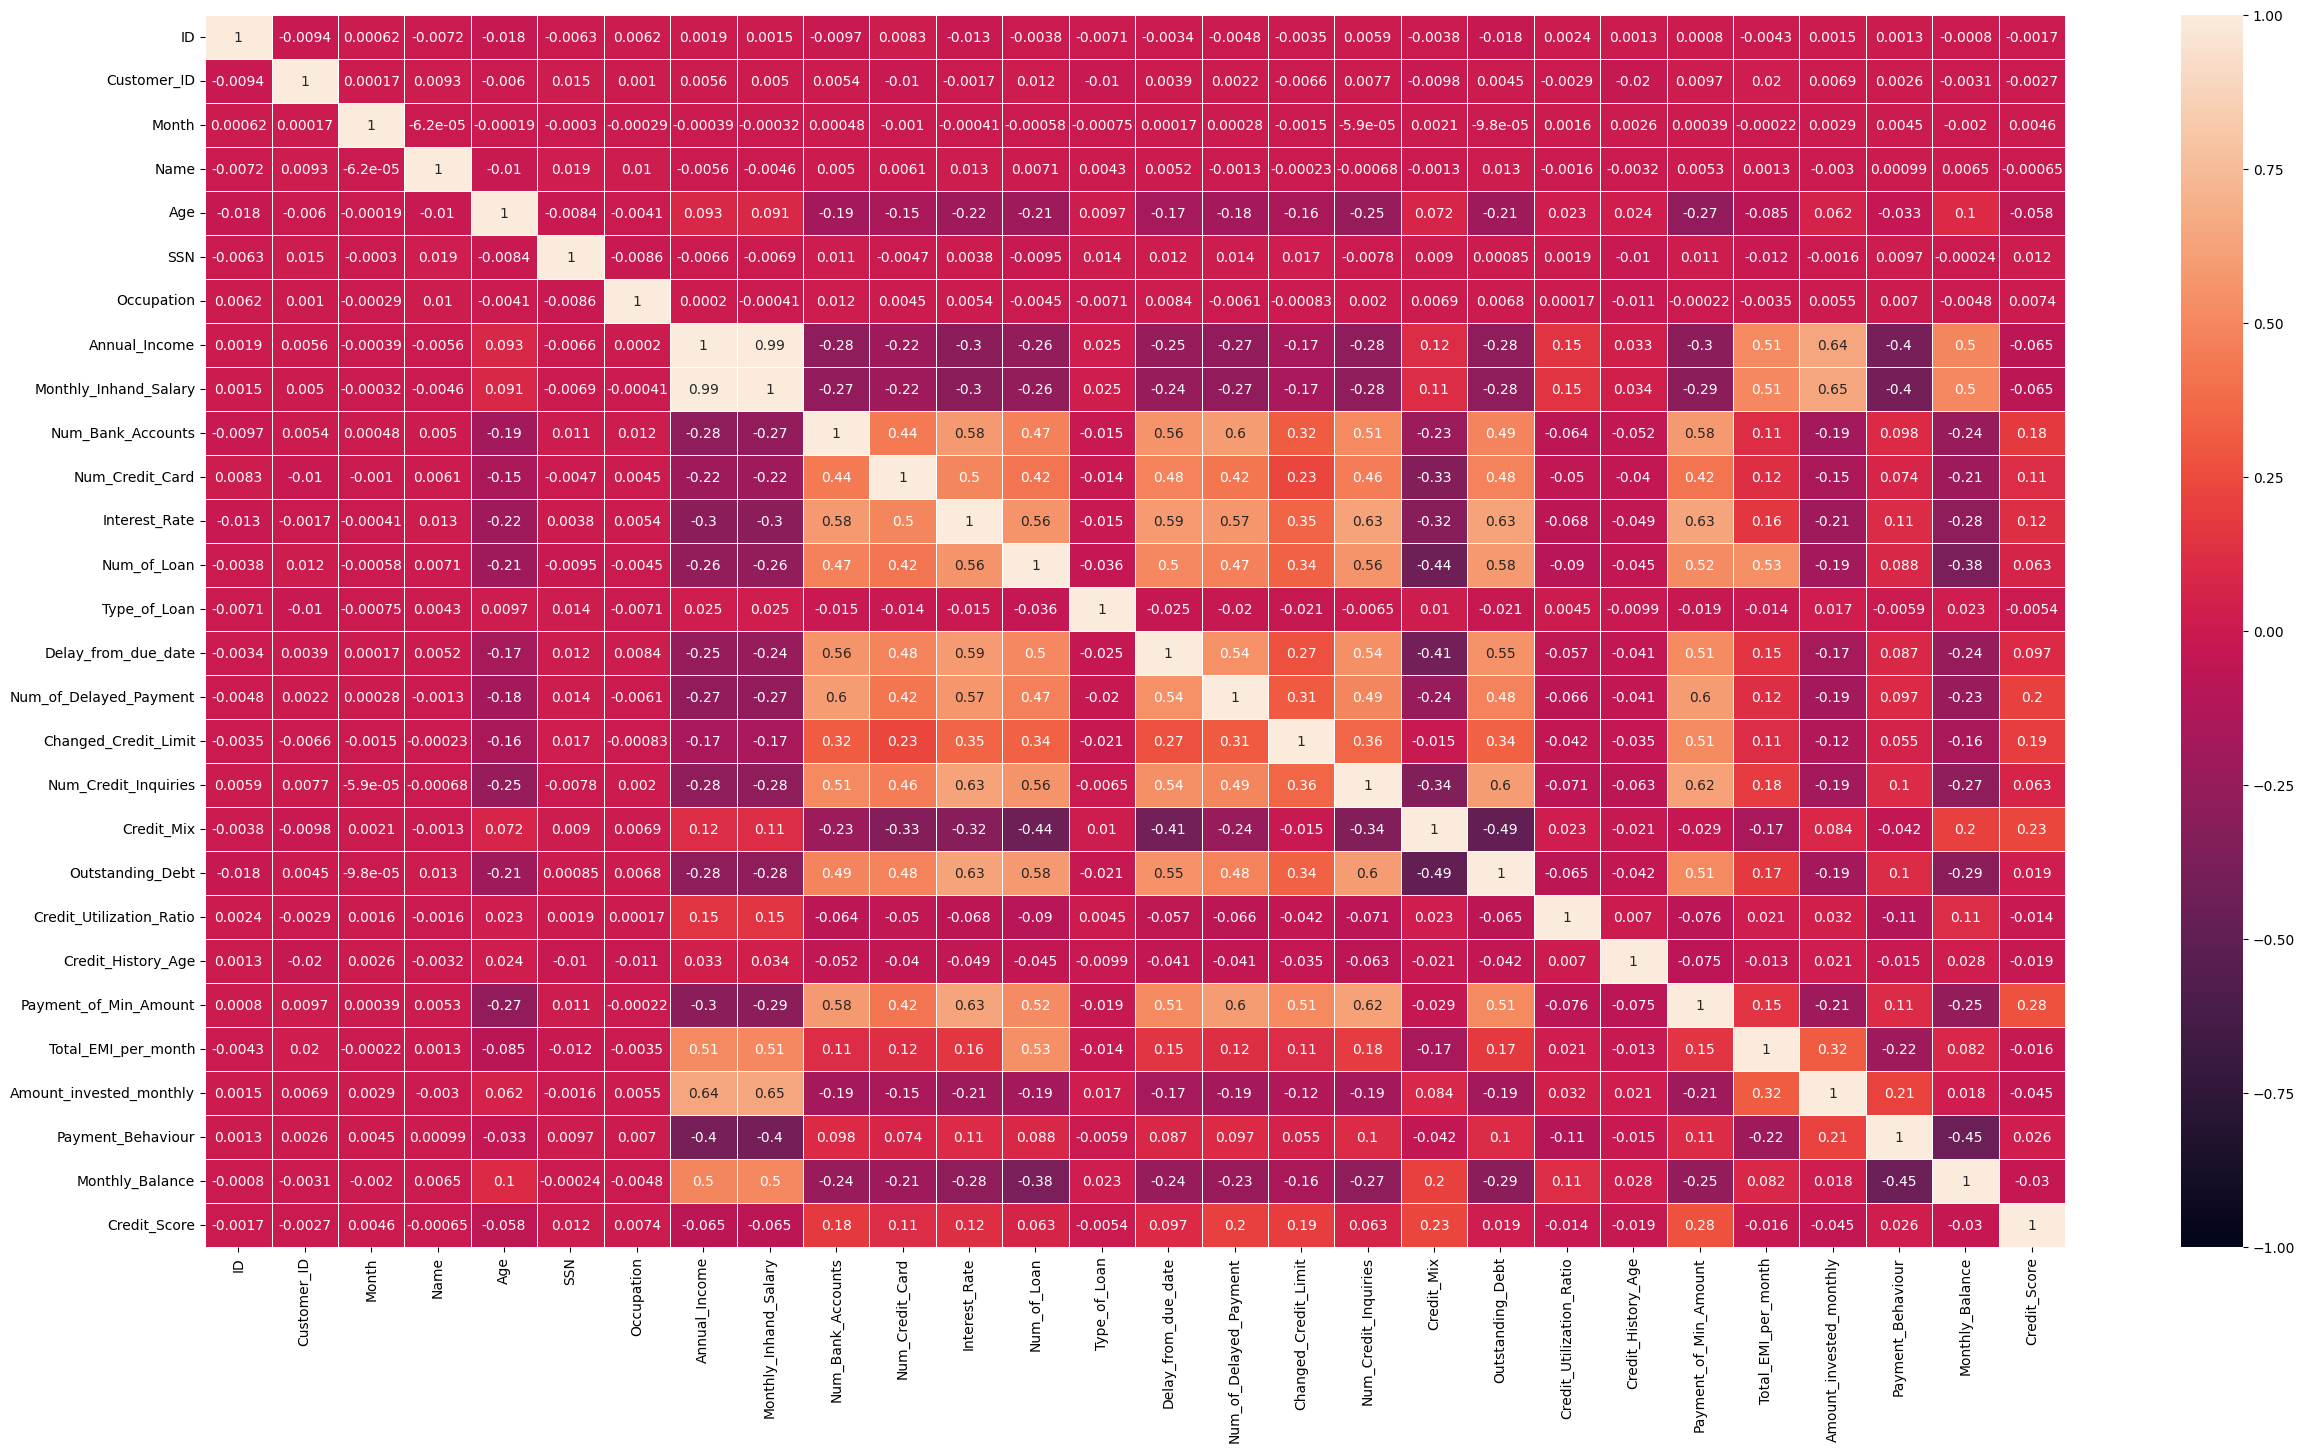

In [33]:
# Coorelation between the variables
from sklearn.preprocessing import LabelEncoder as le

dx = df2.copy()

for c in dx.columns:
  dx[c] = le().fit_transform(dx[c])

plt.figure(figsize=(30, 16))
sns.heatmap(dx.corr(), linewidths=.5, annot=True, vmax=1, vmin=-1)
plt.show()

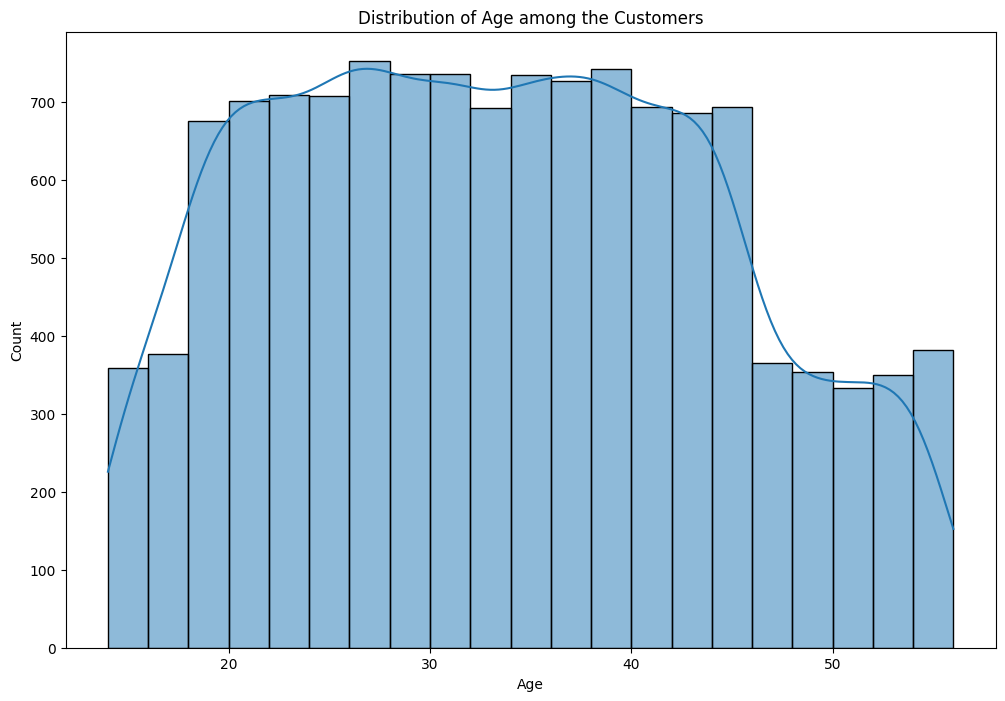

In [34]:
# Distribution of age

ax = df2.groupby('Customer_ID')['Age'].median()

plt.figure(figsize=(12, 8))
sns.histplot(data=ax, binwidth=2, kde=True)
plt.title('Distribution of Age among the Customers')
plt.show()

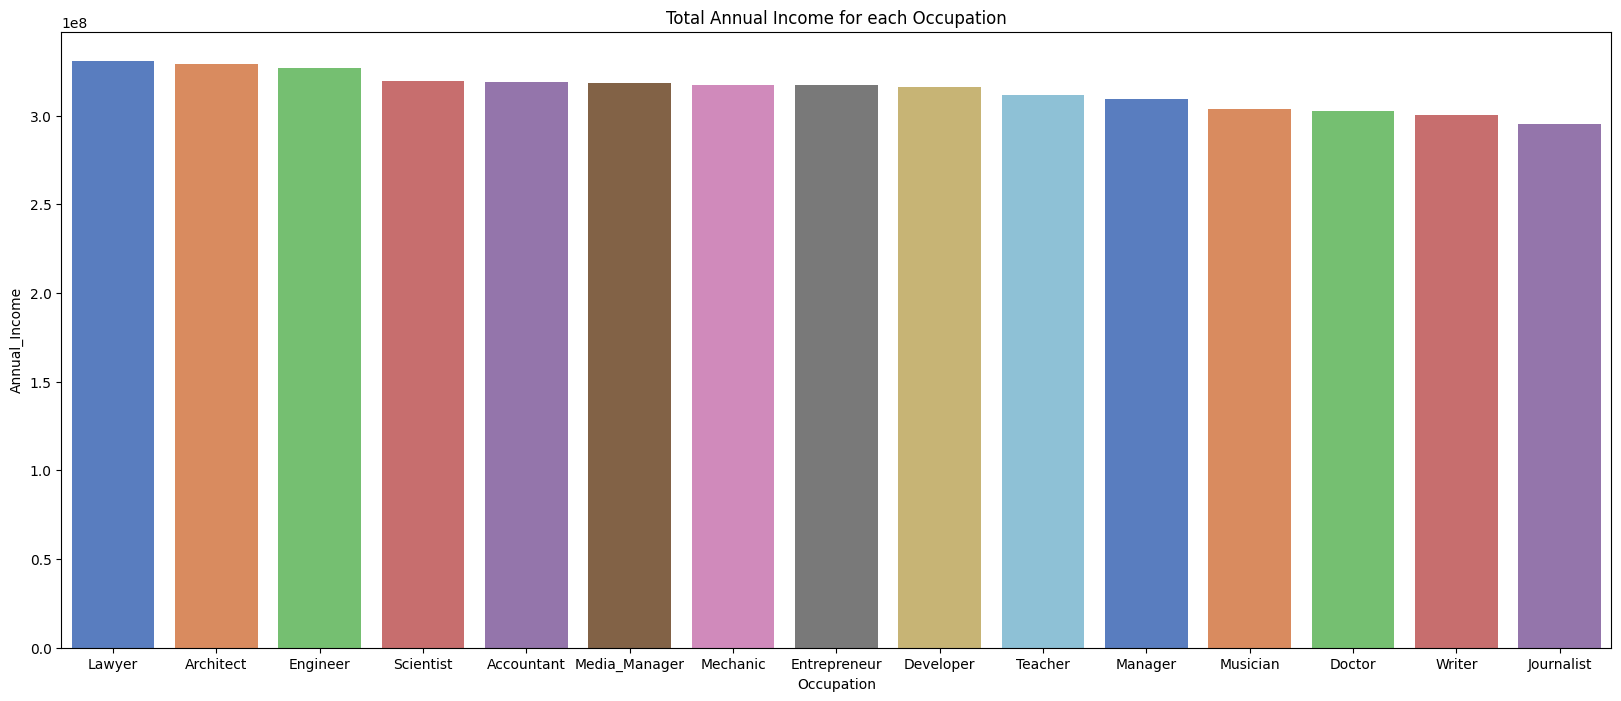

In [35]:
# Total annual income in a given occupation

cx = df2.groupby('Occupation')['Annual_Income'].sum().reset_index().sort_values(by='Annual_Income', ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(data=cx, x='Occupation', y='Annual_Income', hue='Occupation', palette='muted')
plt.title('Total Annual Income for each Occupation')
plt.show()

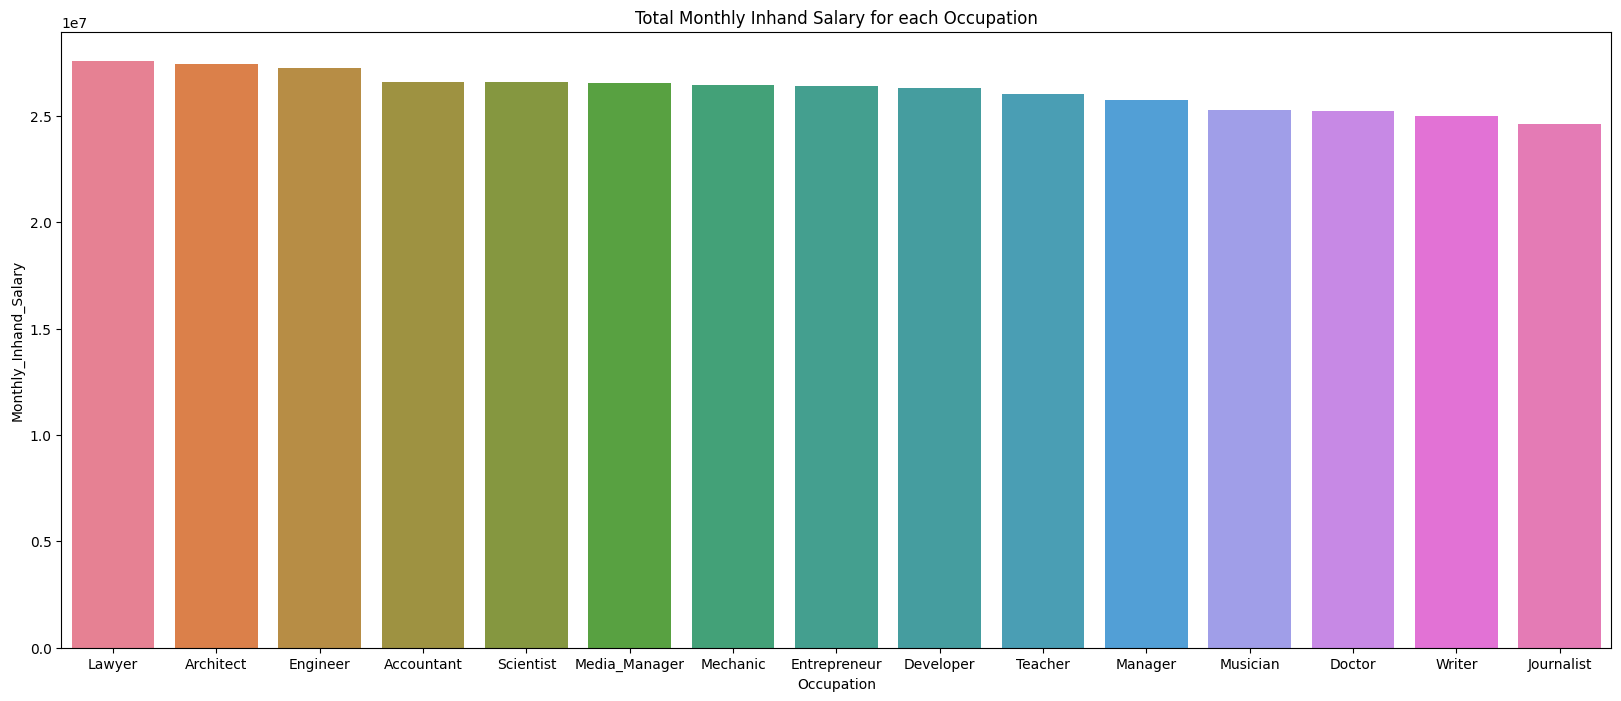

In [36]:
# Total monthly income in a given occupation

cx = df2.groupby('Occupation')['Monthly_Inhand_Salary'].sum().reset_index().sort_values(by='Monthly_Inhand_Salary', ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(data=cx, x='Occupation', y='Monthly_Inhand_Salary', hue='Occupation', palette='husl')
plt.title('Total Monthly Inhand Salary for each Occupation')
plt.show()

#### **MODELLING**

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC

from sklearn.metrics import confusion_matrix as cm, accuracy_score, precision_score, recall_score, f1_score

In [38]:
# Transform the data values into a standardized form
df3 = df2.copy().drop(columns=['Customer_ID', 'ID'])

for c in df3.columns:
  df3[c] = le().fit_transform(df3[c])

y = df3.pop('Credit_Score')
X = df3

# Data resampling
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, shuffle=True, stratify=y_resampled)

In [39]:
# ML Models

models = {
  'K_Nearest_Neighbour': KNN(n_neighbors=5, weights='distance', algorithm='ball_tree', leaf_size=30),
  'Decision_Tree': DTC(criterion='entropy', max_depth=40, splitter='best', random_state=42, max_features='sqrt'),
  'Random_Forest': RFC(n_estimators=150, criterion='gini', max_features='sqrt', random_state=42, max_depth=30, class_weight='balanced_subsample')
}

K_Nearest_Neighbour Performances
Accuracy: 70.58%
Precision: 71.07%
Recall: 70.58%
F1_Score: 67.81%



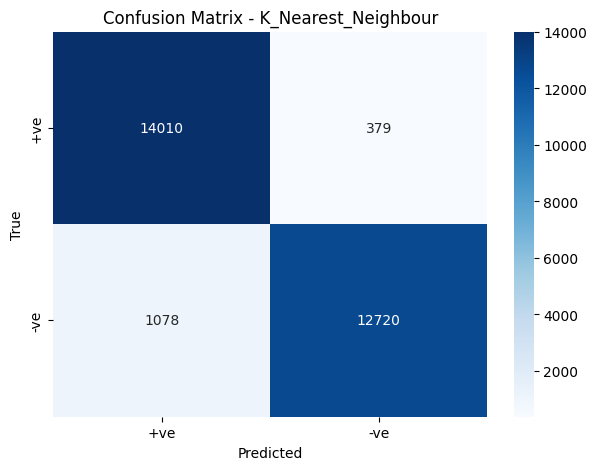

Decision_Tree Performances
Accuracy: 76.90%
Precision: 76.92%
Recall: 76.90%
F1_Score: 76.91%



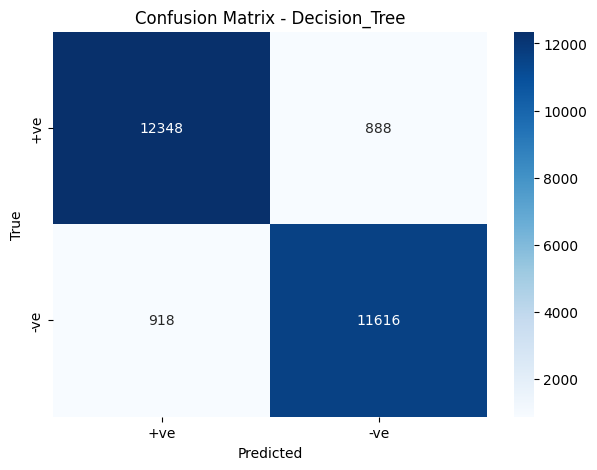

Random_Forest Performances
Accuracy: 85.23%
Precision: 85.21%
Recall: 85.23%
F1_Score: 85.12%



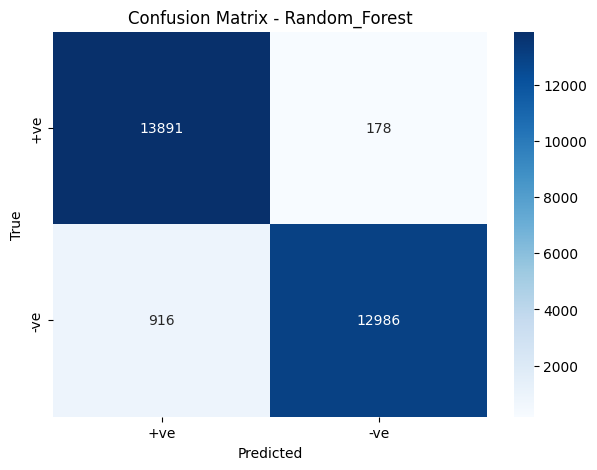

In [40]:
# Training the model
def train(X_train, y_train, model):
  return model.fit(X_train, y_train)

# Test the model performance
def perf(pred, y_test, model):
  acc = accuracy_score(y_test, pred)*100
  prec = precision_score(y_test, pred, average='weighted')*100
  rec = recall_score(y_test, pred, average='weighted')*100
  f1 = f1_score(y_test, pred, average='weighted')*100

  print(f'{model} Performances')
  print(f'Accuracy: {acc:.2f}%')
  print(f'Precision: {prec:.2f}%')
  print(f'Recall: {rec:.2f}%')
  print(f'F1_Score: {f1:.2f}%')
  print()

  c = cm(y_test, pred, labels=[0,1])
  plt.figure(figsize=(7, 5))
  sns.heatmap(c, annot=True, fmt="d", cmap="Blues", xticklabels=["+ve", "-ve"], yticklabels=["+ve", "-ve"])
  plt.title(f"Confusion Matrix - {model}")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

trained = dict()

for m in models:
  model = models.get(m)

  t = train(X_train=X_train, y_train=y_train, model=model)
  trained.update({m: t})

  pred = t.predict(X_test)

  p = perf(pred=pred, y_test=y_test, model=m)

# trained

In [41]:
# Predict the Credit_Score from the test.csv file

df_test = pd.read_csv('/kaggle/input/credit-score-classification/test.csv')

df_test2 = df_test.copy().drop(columns=['ID', 'Customer_ID'])
for c in df_test2.columns:
  df_test2[c] = le().fit_transform(df_test2[c])

results = pd.DataFrame(columns=[model for model in trained])

for model in trained:
  m = trained.get(model)
  predicts = m.predict(df_test2)
  p = np.array(predicts.squeeze())

  results[model] = p

results.to_csv('test_results.csv', index=False, index_label=False)